# Aufgabe 3 - Tiefe Einblicke ins Institut: Reloaded

Den Code immer nachvollziehbar kommentieren! Bitte beachtet, dass das Notebook von Anfang bis Ende ohne Fehler durchlaufen muss und dass die requirements.txt Datei aktualisiert wird. 

In [13]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F  
import torchvision.transforms as T
import torch.optim as optim
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt 

#from torchmetrics import Accuracy
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score

## Teilaufgabe a): Trainings-, Test-und Validierungsdatenset

In [14]:
#Abgeänderter Code von 2a Trainingsdaten werden nochmal 80/20 gesplittet. Auch hier sind die Räume gleichmäßig repräsentiert

import numpy as np
from sklearn.model_selection import train_test_split
import random

training_path_list = []  # ["./pfad/zu/bildA.png","./pfad/zu/bildB.png",...]
test_path_list = []  # ["./pfad/zu/bildC.png","./pfad/zu/bildD.png",...]

# add all paths to one array
flur_list = []
labor_list = []
buero_list = []
kueche_list = []

for i in range(1,26):
    flur_list.append("./Bilder/Flur/Flur%d.jpg"% i)
    labor_list.append("./Bilder/Labor/Labor%d.jpg"% i)
    buero_list.append("./Bilder/Professorenbuero/Professorenbuero%d.jpg"% i)
    kueche_list.append("./Bilder/Teekueche/Teekueche%d.jpg"% i)

# split the test and training set    
training_flur2, test_flur  = train_test_split(
    flur_list, test_size=0.2, random_state=1
)
training_labor2, test_labor  = train_test_split(
    labor_list, test_size=0.2, random_state=1
)
training_buero2, test_buero  = train_test_split(
    buero_list, test_size=0.2, random_state=1
)
training_kueche2, test_kueche  = train_test_split(
    kueche_list, test_size=0.2, random_state=1
)

#training_path_list = training_flur + training_labor + training_buero + training_kueche
test_path_list = test_flur + test_labor + test_buero + test_kueche # 5 + 5 + 5 + 5

training_flur, val_flur  = train_test_split(
    training_flur2, test_size=0.2, random_state=1
)
training_labor, val_labor  = train_test_split(
    training_labor2, test_size=0.2, random_state=1
)
training_buero, val_buero  = train_test_split(
    training_buero2, test_size=0.2, random_state=1
)
training_kueche, val_kueche  = train_test_split(
    training_kueche2, test_size=0.2, random_state=1
)

training_path_list = training_flur + training_labor + training_buero + training_kueche #16 + 16 + 16 + 16
validation_path_list = val_flur + val_labor + val_buero + val_kueche # 4 + 4 + 4 + 4

#random.shuffle(training_path_list)
#random.shuffle(test_path_list)
#random.shuffle(validation_path_list)

print(validation_path_list)



 

['./Bilder/Flur/Flur5.jpg', './Bilder/Flur/Flur9.jpg', './Bilder/Flur/Flur7.jpg', './Bilder/Flur/Flur17.jpg', './Bilder/Labor/Labor5.jpg', './Bilder/Labor/Labor9.jpg', './Bilder/Labor/Labor7.jpg', './Bilder/Labor/Labor17.jpg', './Bilder/Professorenbuero/Professorenbuero5.jpg', './Bilder/Professorenbuero/Professorenbuero9.jpg', './Bilder/Professorenbuero/Professorenbuero7.jpg', './Bilder/Professorenbuero/Professorenbuero17.jpg', './Bilder/Teekueche/Teekueche5.jpg', './Bilder/Teekueche/Teekueche9.jpg', './Bilder/Teekueche/Teekueche7.jpg', './Bilder/Teekueche/Teekueche17.jpg']


## Teilaufgabe b): CNN definieren und implementieren

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = 3
        self.hidden_units = 10
        self.output_shape = 4 # Klassen
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,         #Neue Werte werden mit Bias und Gewichten berechnet. Backpropagation: Gewichte werden angepasst
                      out_channels=self.hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=self.hidden_units,
                      out_channels=self.hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  #MaxPool2d verringert die Auflösung der Matrix und kann so wichtigere Merkmale hervorheben
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=self.hidden_units,
                      out_channels=self.hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.hidden_units,
                  out_channels=self.hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features= self.hidden_units*56*56, #Shape nach conv_block_2
                     out_features=self.output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        return x
    

## Teilaufgabe c): Training und Test mit CNN

Datenset-Klasse um mit Pytorch Bilder zu laden. 

Input sind: 
- Liste mit Pfaden zu Bildern
- Liste mit dazugehörigen Labels (numerisch darstellen!) 
- Transformation der Bilder


In [16]:
class ROBDataset(Dataset):
    def __init__(self, img_path_list, img_labels, transform=None):
        #print("Länge list/labels: ",len(img_path_list), len(img_labels))
        # Pfade zu den Bildern als list
        self.img_path_list = img_path_list
        
        # Dazugehörige Labels zu den Bildern als list
        self.img_labels = img_labels
        
        # Transformations der Bilder
        self.transform = transform

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        # Bild laden
        img_path = self.img_path_list[idx]
        #print("Path: ",img_path)
        image = read_image(img_path)
        
        # Label laden
        label = self.img_labels[idx]
        
        # Transformieren
        if self.transform:
            image = self.transform(image)
            
        return image.float(), int(label)

Trainingsiteration über alle Bilder.

Inputs sind:
- Pytorch dataloader Object über das iteriert wird
- bool do_backprob Parameter um Backpropagation durchzuführen oder nicht

In [17]:
# Iterating over the entire data set once
def run_iteration(dataloader, do_backprob=True):
    global net, optimizer, criterion
    loss_iter = []
    acc_iter = []
    for batch_x, batch_y in dataloader:
        # To device
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        y_predict = net(batch_x)
        loss = criterion(y_predict, batch_y)
        if do_backprob:
            loss.backward()
            optimizer.step()

        # statistics
        loss_iter.append(loss.detach().cpu().numpy())
        
        _, predicted = torch.max(torch.softmax(y_predict, dim=1),1)

        #accuracy_score = Accuracy(task="multiclass", num_classes=4)
        acc_iter.append(accuracy_score(batch_y.detach().cpu().numpy(), 
                                       predicted.detach().cpu().numpy()))

        print("F1_Score: ", f1_score(batch_y.detach().cpu().numpy(), predicted.detach().cpu().numpy(),average=None))
        print("Recall: ", recall_score(batch_y.detach().cpu().numpy(), predicted.detach().cpu().numpy(),average=None))
        print("Precision: ", precision_score(batch_y.detach().cpu().numpy(), predicted.detach().cpu().numpy(),average=None))
        cm = confusion_matrix(batch_y.detach().cpu().numpy(), predicted.detach().cpu().numpy())
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        
    
    return np.mean(loss_iter), np.mean(acc_iter), disp

Komplette Durchführung eines Trainings
Die Variablen y_train, y_val und y_test müssen noch gesetzt werden. Diese Listen beinhalten die entsprechenden Labels als numerische Darstellung.

In [18]:
y_train = torch.tensor([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3])#16+16+16+16
y_test = torch.tensor([0,0,0,0,0,1,1,1,1,1,2,2,2,2,2,3,3,3,3,3])#5+5+5+5+5
y_val = torch.tensor([0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]) #4+4+4+4
#print(y_train.shape)
#print(y_test.shape)
#print(y_val.shape)

Running on  cpu

Started Training
Epoch 1 from 10
F1_Score:  [0.31578947 0.         0.         0.        ]
Recall:  [1. 0. 0. 0.]
Precision:  [0.1875 0.     0.     0.    ]
F1_Score:  [0.         0.22222222 0.         0.        ]
Recall:  [0. 1. 0. 0.]
Precision:  [0.    0.125 0.    0.   ]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.  0.4 0.  0. ]
Recall:  [0. 1. 0. 0.]
Precision:  [0.   0.25 0.   0.  ]
F1_Score:  [0.         0.         0.         0.31578947]
Recall:  [0. 0. 0. 1.]
Precision:  [0.     0.     0.     0.1875]
	Train Loss	 1.5523328
	Train Acc.	 0.1875


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.4 0.  0.  0. ]
Recall:  [1. 0. 0. 0.]
Precision:  [0.25 0.   0.   0.  ]
	Val Loss	 1.3998315
	Val Acc.	 0.25
Epoch 2 from 10
F1_Score:  [0.22222222 0.         0.         0.        ]
Recall:  [1. 0. 0. 0.]
Precision:  [0.125 0.    0.    0.   ]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.85714286 0.         0.66666667 0.        ]
Recall:  [1. 0. 1. 0.]
Precision:  [0.75 0.   0.5  0.  ]
F1_Score:  [0.72727273 0.         0.57142857 0.        ]
Recall:  [1.  0.  0.8 0. ]
Precision:  [0.57142857 0.         0.44444444 0.        ]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [1.  0.  0.5 0. ]
Recall:  [1. 0. 1. 0.]
Precision:  [1.         0.         0.33333333 0.        ]
	Train Loss	 1.3671707
	Train Acc.	 0.4375
F1_Score:  [0.57142857 0.4        0.5        0.        ]
Recall:  [0.5  0.25 1.   0.  ]
Precision:  [0.66666667 1.         0.33333333 0.        ]
	Val Loss	 1.2878988
	Val Acc.	 0.4375
Epoch 3 from 10


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.72727273 0.         0.61538462 0.4       ]
Recall:  [0.8  0.   1.   0.25]
Precision:  [0.66666667 0.         0.44444444 1.        ]
F1_Score:  [1.         0.66666667 0.4        0.57142857]
Recall:  [1.  0.5 1.  0.4]
Precision:  [1.   1.   0.25 1.  ]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.83333333 1.         0.5        0.8       ]
Recall:  [0.83333333 1.         0.5        0.8       ]
Precision:  [0.83333333 1.         0.5        0.8       ]
F1_Score:  [0.5        0.47058824 0.         0.        ]
Recall:  [0.5 1.  0.  0. ]
Precision:  [0.5        0.30769231 0.         0.        ]
	Train Loss	 1.1579506
	Train Acc.	 0.578125


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.4        0.5        0.         0.28571429]
Recall:  [0.25 1.   0.   0.25]
Precision:  [1.         0.33333333 0.         0.33333333]
	Val Loss	 1.2501827
	Val Acc.	 0.375
Epoch 4 from 10
F1_Score:  [0.8        0.5        0.28571429 0.75      ]
Recall:  [0.66666667 1.         0.16666667 0.75      ]
Precision:  [1.         0.33333333 1.         0.75      ]
F1_Score:  [1.         0.66666667 0.         0.66666667]
Recall:  [1.  1.  0.  0.5]
Precision:  [1.  0.5 0.  1. ]
F1_Score:  [0.61538462 0.66666667 0.75       0.4       ]
Recall:  [0.57142857 1.         0.6        0.5       ]
Precision:  [0.66666667 0.5        1.         0.33333333]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.66666667 0.54545455 0.28571429 0.5       ]
Recall:  [0.5        0.6        1.         0.33333333]
Precision:  [1.         0.5        0.16666667 1.        ]
	Train Loss	 0.9791001
	Train Acc.	 0.578125
F1_Score:  [0.57142857 0.66666667 0.36363636 0.        ]
Recall:  [0.5  0.75 0.5  0.  ]
Precision:  [0.66666667 0.6        0.28571429 0.        ]
	Val Loss	 1.124133
	Val Acc.	 0.4375
Epoch 5 from 10
F1_Score:  [0.85714286 0.4        0.85714286 0.66666667]
Recall:  [1.         0.33333333 0.85714286 0.66666667]
Precision:  [0.75       0.5        0.85714286 0.66666667]
F1_Score:  [0.90909091 0.66666667 0.57142857 0.5       ]
Recall:  [1.  0.5 1.  0.4]
Precision:  [0.83333333 1.         0.4        0.66666667]
F1_Score:  [0.85714286 1.         0.90909091 0.75      ]
Recall:  [1.  1.  1.  0.6]
Precision:  [0.75       1.         0.83333333 1.        ]
F1_Score:  [0.90909091 0.8        0.5        0.85714286]
Recall:  [1.         0.66666667 0.5        1.        ]
Precision:  [0.8333

C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [0.8        0.90909091 0.         0.85714286]
Recall:  [1. 1. 0. 1.]
Precision:  [0.66666667 0.83333333 0.         0.75      ]
F1_Score:  [0.75       0.75       0.85714286 0.66666667]
Recall:  [1.   1.   0.75 0.5 ]
Precision:  [0.6 0.6 1.  1. ]


C:\Users\Chris\miniconda3\envs\ersteUmgebung\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1_Score:  [1. 1. 1. 1.]
Recall:  [1. 1. 1. 1.]
Precision:  [1. 1. 1. 1.]
	Train Loss	 0.5133827
	Train Acc.	 0.84375
F1_Score:  [0.57142857 0.72727273 0.5        0.33333333]
Recall:  [0.5  1.   0.5  0.25]
Precision:  [0.66666667 0.57142857 0.5        0.5       ]
	Val Loss	 1.0914555
	Val Acc.	 0.5625
Epoch 7 from 10
F1_Score:  [0.88888889 1.         1.         0.85714286]
Recall:  [1.   1.   1.   0.75]
Precision:  [0.8 1.  1.  1. ]
F1_Score:  [0.85714286 1.         0.88888889 1.        ]
Recall:  [1.  1.  0.8 1. ]
Precision:  [0.75 1.   1.   1.  ]
F1_Score:  [1. 1. 1. 1.]
Recall:  [1. 1. 1. 1.]
Precision:  [1. 1. 1. 1.]
F1_Score:  [1.         0.83333333 0.88888889 0.88888889]
Recall:  [1.         0.71428571 1.         1.        ]
Precision:  [1.  1.  0.8 0.8]
	Train Loss	 0.27573007
	Train Acc.	 0.9375
F1_Score:  [0.57142857 0.66666667 0.6        0.33333333]
Recall:  [0.5  0.75 0.75 0.25]
Precision:  [0.66666667 0.6        0.5        0.5       ]
	Val Loss	 1.2875743
	Val Acc.	 0.5625


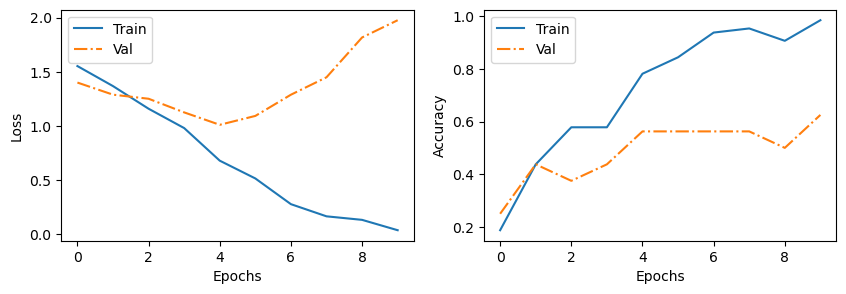

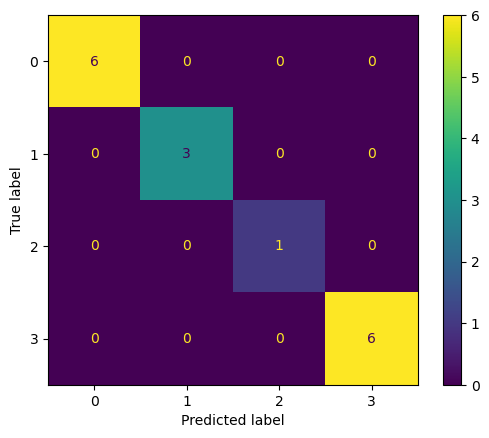

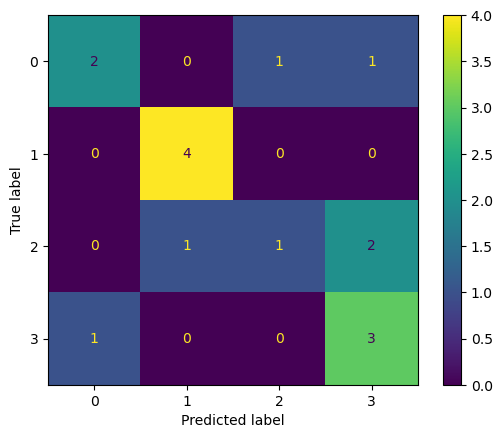

In [19]:
# Training settings - bei Bedarf anpassbar
max_epoch = 10
batch_size = 16
lr = 0.001

# Transformations for dataloader
t_train = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
t_val = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
t_test = T.Compose([T.ToPILImage(),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# Where to do calculations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on ",device)

# Training Data, NOTE: y_train labels need to be set
dataset_train = ROBDataset(training_path_list, y_train, transform=t_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Validation Data, NOTE: y_val labels need to be set
dataset_val = ROBDataset(validation_path_list, y_val, transform=t_train)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Test Data, NOTE: y_test labels need. to be set
dataset_test = ROBDataset(test_path_list, y_test,transform=t_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Network, optimizer and loss initialisation
net = Net()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Los geht's mit Training
print("\nStarted Training")
# Training loss and accuracy per epoch
train_loss_epoch = []
train_acc_epoch = []
# Validation loss and accuracy per epoch
val_loss_epoch = []
val_acc_epoch = []

for epoch in range(0,max_epoch):  # loop over the dataset multiple times
    print(f"Epoch {epoch+1} from {max_epoch}")
    
    ### TRAINING ###
    net.train()
    train_loss_iter, train_acc_iter, dispT = run_iteration(dataloader_train)

    # Logging loss and accuarcy of training iteration
    train_loss_epoch.append(train_loss_iter)
    train_acc_epoch.append(train_acc_iter)
    print("\tTrain Loss\t",train_loss_iter)
    print("\tTrain Acc.\t",train_acc_iter)
    
    ### VALIDATION ###
    with torch.no_grad():  # No gradient calculation
        net.eval()
        val_loss_iter, val_acc_iter, dispV = run_iteration(dataloader_val,do_backprob=False)

        # Logging loss and accuarcy of validation iteration
        val_loss_epoch.append(val_loss_iter)
        val_acc_epoch.append(val_acc_iter)
        print("\tVal Loss\t",val_loss_iter)
        print("\tVal Acc.\t",val_acc_iter)

# Plotting results
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,3))
ax[0].plot(train_loss_epoch,label="Train")
ax[0].plot(val_loss_epoch,label="Val",linestyle="-.")
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(train_acc_epoch,label="Train")
ax[1].plot(val_acc_epoch,label="Val",linestyle="-.")
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.savefig("loss_augmentation.png",format="png",bbox_inches="tight")
plt.show()
dispT.plot()
dispV.plot()

## Teilaufgabe d): Augmentierung

In [22]:
"""Es können zusätzlich Ausschnitte aus den Bildern in die Datensätze hinzugefügt werden. Außerdem könnten die Bilder gespiegelt werden.
Die Helligkeit kann geändert werden, um verschiedene Tageszeiten oder das Ausschalten des Lichts zu simulieren. Die Bilder können auch bewusst unschärfer
gemacht werden. Dies kann wichtige Merkmale aus den Bildern hervorheben. Ähnlich dem MaxPooling"""

'Es können zusätzlich Ausschnitte aus den Bildern in die Datensätze hinzugefügt werden. Außerdem könnten die Bilder gespiegelt werden.\nDie Helligkeit kann geändert werden, um verschiedene Tageszeiten oder das Ausschalten des Lichts zu simulieren. Die Bilder können auch bewusst unschärfer\ngemacht werden. Dies kann wichtige Merkmale aus den Bildern hervorheben. Ähnlich dem MaxPooling'

## Teilaufgabe e): Early Stopping